# Laboratório de Interpolação #

Neste laboratório, iremos implementar os métodos de Interpolação Polinomial, Lagrange e Newton

## Preliminares ##

Antes de mais nada, precisamos de uma função que, dados os coeficientes `c` de um polinômio de grau `len(c)-1` e um valor `x`, calcule `y = f(x)`:

In [65]:
import numpy as np

In [66]:
def resolveTS(A,b): #A Triangular Superior
    x = np.zeros(len(A))
    for i in range(len(A)-1,-1,-1):
        x[i] = (b[i] - (A[i][i+1:]*x[i+1:]).sum())/A[i][i]
    return x

def resolveTI(A,b): #A Triangular Inferior
    x = np.zeros(len(b))
    for i in range(len(b)):
        x[i] = (b[i] - (A[i][:i]*x[:i]).sum())/A[i][i]
    return x

In [67]:
def eliminacaoGaussianaSimples(A,b):
    Au = np.zeros(A.shape)
    Ax = np.concatenate((A,b.reshape(len(b),1)),axis=1)
    for i in range(len(Ax)-1):
        Ax[i+1:] -= (Ax[i+1:,i]/Ax[i][i]).reshape((len(Au[i+1:]),1))*Ax[i]
        
    return resolveTS(Ax[:,:len(b)],Ax[:,len(b)])

In [91]:
def resolvePoli(c,x):
    y = np.array([c[i]*(x**i) for i in range(len(c))])
    return np.sum(y)
resolvePoli([20,3,4],1)

27

Precisamos também de uma função que dado um conjunto ordenados de pontos `x`, um valor a ser interpolado `xalvo` e um número `n`, escolha um intervalo com `n` que minimize a distância entre `xalvo` e os pontos do intervalo e retorne `n` valores de `x` e `y` deste intervalo:

In [69]:
def escolheIntervalo(x,y,xalvo,n):
    d = np.abs(xalvo - x)
    vx = np.copy(x)
    vy = np.copy(y)
    for i in range(len(x)-n):
        m = np.argmax(d)
        vx = np.delete(vx,m)
        vy = np.delete(vy,m)
        d = np.delete(d,m)
    return vx,vy

## Interpolação Polinomial ##

Na interpolação polinomial, o objetivo é descobrir os coeficientes de um polinômio de ordem `n-1` que passe pelos `n` pontos utilizados para gerar o polinômio. Ou seja, quanto mais pontos são utilizados, maior o grau do polinômio gerado. Para gerar este polinômio, basta substituir os valores $(x_i,y_i)$ no polinomio genérico e, a partir das equações geradas, montar um sistema linear para descobrir os coeficientes.

Por exemplo, com três observações pode-se gerar um polinômio de terceiro grau, utilizando a forma abaixo:

$$
\left[ \begin{array} { c c c } { x _ { 1} ^ { 2} } & { x _ { 1} } & { 1} \\ { x _ { 2} ^ { 2} } & { x _ { 2} } & { 1} \\ { x _ { 3} ^ { 2} } & { x _ { 3} } & { 1} \end{array} \right] \left[ \begin{array} { l } { a } \\ { b } \\ { c } \end{array} \right] = \left[ \begin{array} { l } { y _ { 1} } \\ { y _ { 2} } \\ { y _ { 3} } \end{array} \right]
$$

Independente da quantidade de pontos, a matriz gerada sempre terá a característica de possuir 1 na última coluna ($x^0$), com cada coluna anterior sendo a posterior multiplicada por $x$.

Faça uma função que, dado um vetor `x` e um `y` contendo os pontos a interpolar, retorne o vetor de coeficientes `c` de um polinômio que passe por todos os pontos de $(x,y)$:

In [81]:
def interpoli(x,y):
    
    m=np.zeros((len(x),len(x)),dtype='float')
    
    for i in range(len(x)):
        m[:,i]=x**(len(x)-i-1)
        
    return eliminacaoGaussianaSimples(m,y)

In [88]:
x = np.array([1250,1000,750])
y = np.array([25,15,10])
coef = interpoli(x,y)
print(coef)

resolvePoli(coef,850)

[ 4.0e-05 -5.0e-02  2.5e+01]


18062457.500040002

Verifique o funcionamento da sua função para os pontos abaixo. Escolha 3 intervalos para o ponto 2008, com 2, 3 e 5 pontos. Ache os coeficientes para estes três intervalos e plote as três funções usando o código abaixo:

ValueError: x and y must have same first dimension, but have shapes (500,) and (1,)

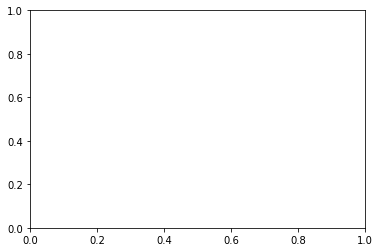

In [79]:
import matplotlib.pyplot as plt
%matplotlib inline

xauto = np.array([2005,2006,2007,2009,2010,2011,2013,2014,2015,2016])
yauto = np.array([156490,173169,191347,230612,252274,271885,311179,328715,340477,347799])

x08_1,y08_1 = escolheIntervalo(xauto,yauto,2008,2)
x08_2,y08_2 = escolheIntervalo(xauto,yauto,2008,3)
x08_4,y08_4 = escolheIntervalo(xauto,yauto,2008,5)

c08_1 = interpoli(x08_1,y08_1)
c08_2 = interpoli(x08_2,y08_2)
c08_4 = interpoli(x08_4,y08_4)

xplot = np.linspace(2005,2016,500)

yp08_1 = resolvePoli(c08_1,xplot)
yp08_2 = resolvePoli(c08_2,xplot)
yp08_4 = resolvePoli(c08_4,xplot)

plt.plot(xplot,yp08_1.round(2),'g-.',label='Linear')
plt.plot(xplot,yp08_2.round(2),'y-',label='Quadratico')
plt.plot(xplot,yp08_4.round(2),'r--',label='Quarto Grau')
plt.plot(xauto,yauto,'b.',label='Original')
plt.ylabel('Numero de Automoveis em Manaus')
plt.xlabel('Ano')
plt.legend(loc='upper left')
plt.title("Intervalos para 2008")
plt.show()

Repita o processo acima para o ano de 2012:

## Polinômio de Lagrange ##

Vamos agora implementar o polinômio de Lagrange. Nele, ao invés de calcular os coeficientes do poliômio, se calcula diretamente o valor de f(x) baseado nos pontos usados para interpolar.

A fórmula do polinômio de Lagrange é dada abaixo:

$$
L _ { n } ( x ) = \sum _ { i = 0} ^ { n } y _ { i } \prod _ { \substack{j = 0\\j\neq i}} ^ { n } \frac { x - x _ { j } } { x _ { i } - x _ { j } }
$$

Implemente uma função que receba os pontos `x`, `y` e o valor a ser interpolado `xalvo` e retorne o valor de `f(xalvo)`:

In [40]:
def lagrange(x,y,xalvo):
    yalvo=0
    for i in range(len(y)):
        div=1
        for j in range(len(x)):
            if i != j:
                div*=(xalvo-x[j])/(x[i]-x[j])
                
        yalvo+=y[i]*div
    
    return yalvo

In [42]:
lagrange(xauto,yauto,2005)

156490.0

Uma diferença na implementação do método de lagrange pode ser deixar a divisão para depois do produtório, diminuindo o número de divisões feitas pelo programa (ver algoritmo nos slides).

Implemente uma versão de Lagrange que faça a divisão somente após o produtório:

In [27]:
def lagranged(x,y,xalvo):
    yalvo=0
    for i in range(len(y)):
        num=1
        den=1
        for j in range(len(x)):
            if i!=j:
                num*=(xalvo-x[j])
                den*=(x[i]-x[j])
        yalvo+=y[i]*(num/den)
        
    return yalvo

In [28]:
lagranged(xauto,yauto,2005)

156490.0

Verifique o funcionamento do polinômio de Lagrange nos dados de automóveis do exemplo acima, calculando os valores para 2008 e 2012 com 2,3 e 5 pontos. Compute a diferença de tempo entre as duas versões implementadas com o `%timeit`:

## Polinômio de Newton ##

Para computar o polinômio de Newton primeiramente deve-se computar o operador de Diferenças Divididas:
$$
\Delta ^ { n } y _ { i } = \frac { \Delta ^ { n - 1} y _ { i + 1} - \Delta ^ { n - 1} y _ { i } } { x _ { i + n } - x _ { i } }
$$

Implemente uma função que, dado `x` e `y`, retorne a matriz `d` com as diferenças divididas:

In [10]:
def difdiv(x,y):
    
    return d

Faça agora uma função que, dado os pontos `x`,`y`, a matriz de diferenças divididas `d` e o ponto a ser interpolado `xalvo`, calcule o valor de `y`, de acordo com o polinômio interpolador de Newton:

$$
P _ { n } ( x ) = y _ { 0} + \sum _ { i = 1} ^ { n } \Delta _ { 0} ^ { i } y _ { 0} \prod _ { j = 0} ^ { i - 1} \left( x - x _ { j } \right)
$$

In [11]:
def poliNewton(x,y,d,xalvo):
    
    return y

Verifique o funcionamento do polinômio de Newton nos dados de automóveis do exemplo acima, calculando os valores para 2008 e 2012 com 2,3 e 5 pontos: